## DATASET

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

Loading the MNIST and Fashion MNIST dataset

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
print()

print('Shape MNIST train:', np.shape(mnist_x_train))
print('Shape Fashion MNIST train:', np.shape(fashion_mnist_x_train))
print()

# Normalization and Padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape MNIST train after padding:', np.shape(mnist_x_train))
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape Fashion MNIST train after padding:', np.shape(mnist_x_train))


Shape MNIST train: (60000, 28, 28)
Shape Fashion MNIST train: (60000, 28, 28)

Shape MNIST train after padding: (60000, 32, 32)
Shape Fashion MNIST train after padding: (60000, 32, 32)


In [ ]:
print(f'Number of MNIST/fashion MNIST training samples: {np.shape(mnist_x_train)[0]}')
print(f'Number of MNIST/fashion MNIST test samples: {np.shape(mnist_x_test)[0]}')
print(f'MNIST/fashion MNIST resolution: {np.shape(mnist_x_test)[1:]}')

Number of MNIST/fashion MNIST training samples: 60000
Number of MNIST/fashion MNIST test samples: 10000
MNIST/fashion MNIST resolution: (32, 32)


Only one channel (grey-scale images).

In [ ]:
N_train, h, w = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

### Data generator
Generator which generates batches. A batch is a couple `x_batch, y_batch`, containing `batchsize` number of samples. `x_batch` represents the input, and it contains images `x`: each image `x` has spatial dimensions $32*32$ and it contains a pair of MNIST-fashion MNIST images added together. `y_batch` represents the ground truth, and it contains the images `y`: each image `y` has spatial dimensions $32*64$ and it contains the same pair of MNIST-fashion MNIST images concatenated along the width.

In [ ]:
def datagenerator(x1, x2, batchsize):
    # x1: first dataset of images. In our case, MNIST dataset (either train or test)
    # x2: second dataset of images. In our case, fashion MNIST dataset (either train or test)

    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_batch = (x1[num1] + x2[num2]) / 2.0
        y_batch = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_batch, y_batch 

In [ ]:
batchsize = 64

In [ ]:
# Generator for creating the training batches
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Generator for creating the validation batches
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize)

Example of a training batch

In [ ]:
x_batch, y_batch = next(train_generator)
print('Shape of the x_batch:', x_batch.shape)
print('Shape of the y_batch:', y_batch.shape)

Shape of the x_batch: (64, 32, 32)
Shape of the y_batch: (64, 32, 64)


The data is already normalized into $[0,1]$

In [ ]:
x_batch[0].min(), x_batch[0].max()

(0.0, 0.8313725490196078)

In [ ]:
y_batch[0].min(), y_batch[0].max()

(0.0, 1.0)

Visualization of a sample in the batch

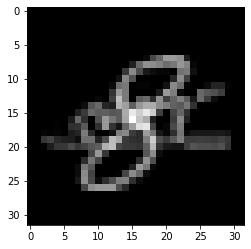

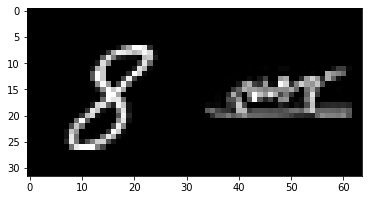

In [ ]:
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()

## MODEL
U-Net (i.e. fully convolutional autoencoder with skip connections). One single encoder, and one decoder (single branch): classic U-net. It computes only a single image: the fashion MNIST image. Then, the MNIST image is obtained by simply subtracting the computed fashion MNIST image from the input image. Finally, the output of the network is the concatenation between the MNIST image and the fashion MNIST image, across the widht.

 Input: $32*32*1$. Two outputs $32*32*1$, which are concatenated together along the width, producing a single output $32*64*1$. U-net with one branch.
 
 The U-net computes the fashion MNIST image and not the MNIST image beacuse we have seen that it is easier to learn the fashion MNIST image.

In [16]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPool2D, concatenate, Concatenate
from tensorflow.keras import Model
import tensorflow.keras as ks

In [61]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    x = ks.layers.Input(shape=input_shape)

    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = ks.layers.MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
        
    # Fashion MNIST image
    y2 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h)

    # MIST image
    y1 = 2*x - y2

    # Actual output: concatenation along the width
    y = concatenate([y1,y2], axis=2)

    return ks.models.Model(x, outputs=y)

In [64]:
unet = build_unet((32,32,1), n_ch=32, L=4, conv_per_L=2)

In [65]:
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_99 (Conv2D)             (None, 32, 32, 32)   320         ['input_8[0][0]']                
                                                                                                  
 re_lu_70 (ReLU)                (None, 32, 32, 32)   0           ['conv2d_99[0][0]']              
                                                                                                  
 conv2d_100 (Conv2D)            (None, 32, 32, 32)   9248        ['re_lu_70[0][0]']               
                                                                                            

$2M$ parameters.

In [66]:
from tensorflow.keras.optimizers import Adam

In [67]:
unet.compile(optimizer=Adam(), loss='mse')

In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
reduce_lr_callback = ReduceLROnPlateau(patience=3, min_delta=0.00001)

callback_checkpoint = ModelCheckpoint('UNET_singBranch.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [69]:
steps_per_epoch = 20000
val_steps = N_test // batchsize

In [70]:
hist = unet.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
20000/20000 [==============================] - 443s 22ms/step - loss: 0.0015 - val_loss: 7.6863e-04 - lr: 0.0010
Epoch 2/50
20000/20000 [==============================] - 441s 22ms/step - loss: 7.3563e-04 - val_loss: 6.6719e-04 - lr: 0.0010
Epoch 3/50
20000/20000 [==============================] - 441s 22ms/step - loss: 6.4580e-04 - val_loss: 6.1713e-04 - lr: 0.0010
Epoch 4/50
20000/20000 [==============================] - 439s 22ms/step - loss: 6.0506e-04 - val_loss: 5.6588e-04 - lr: 0.0010
Epoch 5/50
20000/20000 [==============================] - 438s 22ms/step - loss: 5.8033e-04 - val_loss: 5.6312e-04 - lr: 0.0010
Epoch 6/50
20000/20000 [==============================] - 437s 22ms/step - loss: 5.6261e-04 - val_loss: 5.4125e-04 - lr: 0.0010
Epoch 7/50
20000/20000 [==============================] - 437s 22ms/step - loss: 5.4720e-04 - val_loss: 5.5716e-04 - lr: 0.0010
Epoch 8/50
20000/20000 [==============================] - 438s 22ms/step - loss: 5.3677e-04 - val_loss: 5.42

KeyboardInterrupt: ignored

In [71]:
test_generator1 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(test_generator1)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print('Min:', min(mse_list))
print('Mean:', np.mean(mse_list))
print('Std:', np.std(mse_list))

625/625 [==============================] - 3s 5ms/step - loss: 4.3830e-04
[0.00043183265370316803, 0.0004393371054902673, 0.0004342032771091908, 0.00043042254401370883, 0.0004428891115821898, 0.0004346093046478927, 0.00042903536814264953, 0.00043645757250487804, 0.0004367740184534341, 0.00043830095091834664]
Min: 0.00042903536814264953
Mean: 0.00043538619065657257
Std: 4.038248366436228e-06


Min: $4.3e-4$. Mean: $4.3e-4$. Std: $4e-6$.

**Better scores!!!**

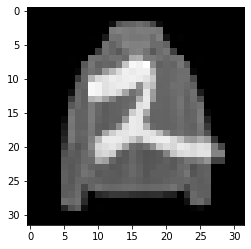

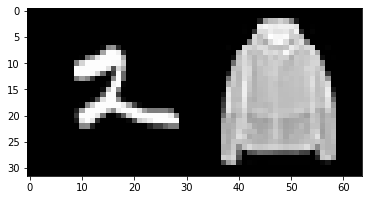

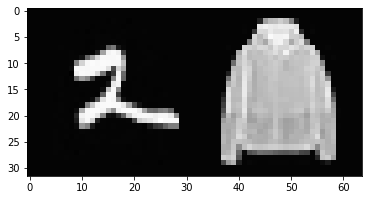

In [75]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()